In [29]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.cluster import KMeans

In [37]:
# Read saved ('pickled') DataFrames (result of Data collection notebook)

startRampLosses = pd.read_pickle("data/pickles/startRampLosses.pkl")
startAdjustLosses = pd.read_pickle("data/pickles/startAdjustLosses.pkl")
startSqueezeLosses = pd.read_pickle("data/pickles/startSqueezeLosses.pkl")
flatTopLosses = pd.read_pickle("data/pickles/flatTopLosses.pkl")

In [173]:
def compareKMeansWithGroundTruth(labels, losses):
    for clusterNo in range(0, 2):
        b1Count = 0
        b2Count = 0
        indicesOfLossesInCluster = np.where(kmeans.labels_ == clusterNo)[0]
        lossesInClusterCount = len(indicesOfLossesInCluster)
        
        for key in losses.index.values[indicesOfLossesInCluster]:
            if key[0] == 'B1':
                b1Count = b1Count + 1
            elif key[0] == 'B2':
                b2Count = b2Count + 1
            else:
                print("Key error - neither B1 nor B2 in key {}".format(key))
                
        assert b1Count + b2Count == lossesInClusterCount
        
        if b1Count == 0:
            print('Cluster', clusterNo, 'has only B2 losses. All',  b2Count, '/', lossesInClusterCount)
        elif b2Count == 0:
            print('Cluster', clusterNo, 'has only B1 losses. All', b1Count, '/', lossesInClusterCount)
        elif (b1Count > b2Count):
            print('Cluster', clusterNo, 'has majority B1 losses. But', b2Count, '/', lossesInClusterCount, 'are B2 losses.')
        elif (b2Count > b1Count):
            print('Cluster', clusterNo, 'has majority B2 losses. But', b1Count, '/', lossesInClusterCount, 'are B1 losses.')
        else:
            print('Cluster', clusterNo, 'has equal number B1, B2 losses:', b1Count, '/', lossesInClusterCount)        

In [174]:
# TODO figure out if you really need to reinstantiate KMeans every time - will fit consider previous data points?
kmeans = KMeans(n_clusters = 2)
kmeans.fit(startRampLosses)
print("start_ramp Cluster memberships:\n{}".format(kmeans.labels_))
# find whether majority of points in cluster 1 are B1 or B2. do the same for cluster 2.
compareKMeansWithGroundTruth(kmeans.labels_, startRampLosses)
# kmeans = KMeans(n_clusters = 2)
kmeans.fit(startAdjustLosses)
print("start_adjust Cluster memberships:\n{}".format(kmeans.labels_))
compareKMeansWithGroundTruth(kmeans.labels_, startAdjustLosses)
# kmeans = KMeans(n_clusters = 2)
kmeans.fit(startSqueezeLosses)
print("start_squeeze Cluster memberships:\n{}".format(kmeans.labels_))
compareKMeansWithGroundTruth(kmeans.labels_, startSqueezeLosses)
# kmeans = KMeans(n_clusters = 2)
kmeans.fit(flatTopLosses)
print("flat_top Cluster memberships:\n{}".format(kmeans.labels_))
compareKMeansWithGroundTruth(kmeans.labels_, flatTopLosses)

start_ramp Cluster memberships:
[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0
 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0
 1 1 1 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 1 0 1 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 0 0 0 0 0 1]
Cluster 0 has majority B1 losses. But 40 / 87 are B2 losses.
Cluster 1 has majority B2 losses. But 104 / 215 are B1 losses.
start_adjust Cluster memberships:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1

In [188]:
# dbscan
from sklearn.cluster import DBSCAN
# eps - "The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not
#        a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose 
#        appropriately for your data set and distance function."
# min_samples - "The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
#                This includes the point itself."
# 
dbs = clustering = DBSCAN(eps=0.9, min_samples=len(startRampLosses) / 2)
dbs.fit(startRampLosses)
print("start_ramp Cluster memberships:\n{}".format(dbs.labels_)) # Outliers are assigned to the -1 cluster

start_ramp Cluster memberships:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


<IPython.core.display.Javascript object>


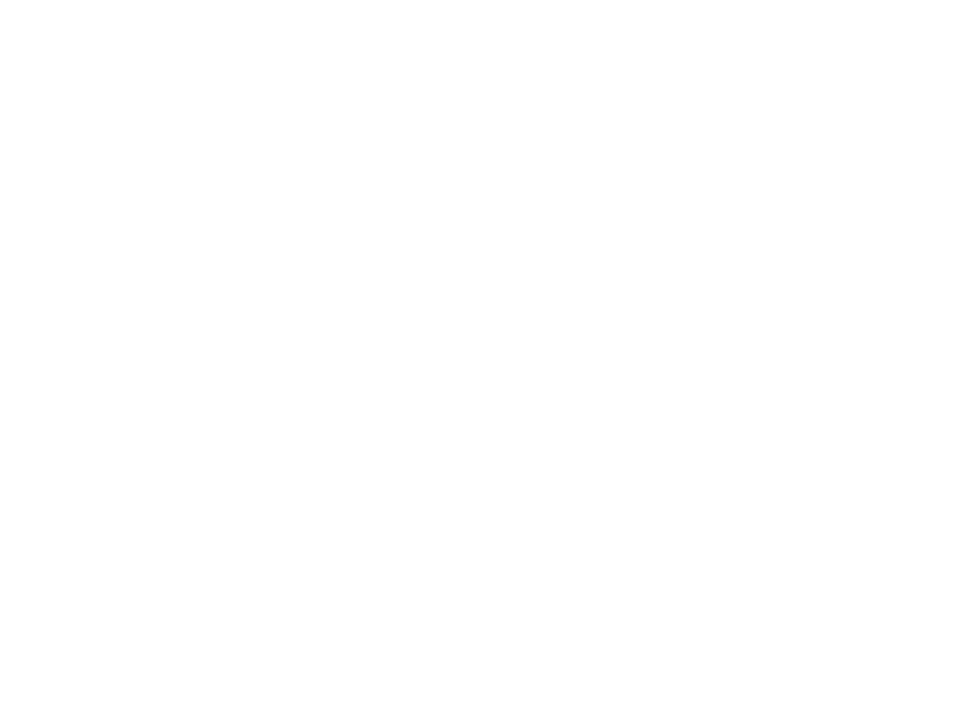

Text(0, 0.5, 'Loss')

In [7]:
# Data
df = pd.DataFrame({
    'B1': startRampLosses.loc['B1']['TCP.C6x7'],
    'B2': startRampLosses.loc['B2']['TCP.C6x7']
})
 
# multiple line plot
plt.figure()
plt.plot('B1', data=df, marker='x', color='red')
plt.plot('B2', data=df, marker='x', color='black')
plt.legend()
plt.title('Plot of the loss registered in TCP.C6x7 against the fill number')
plt.xlabel('Fill')
plt.ylabel('Loss')


<IPython.core.display.Javascript object>


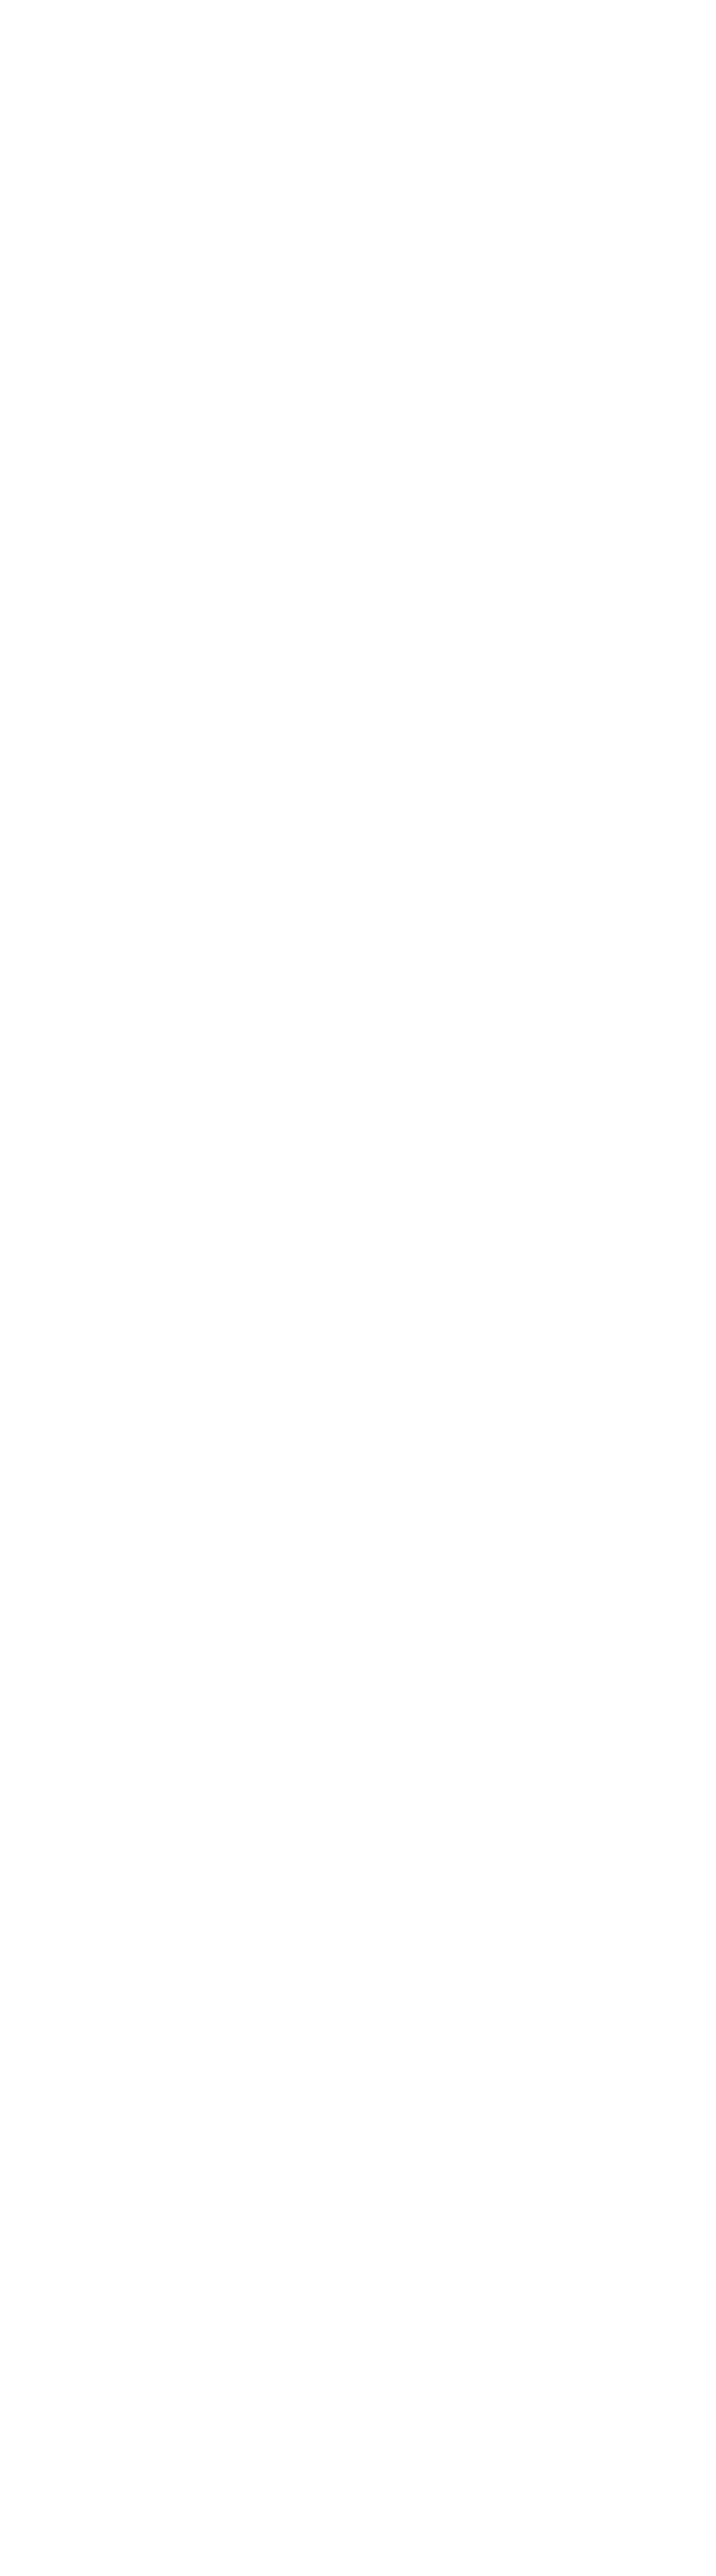

In [8]:
plt.figure(figsize=(10, 36))
ncols = 3;
nrows = math.ceil(startRampLosses.shape[1] / ncols)
i = 1;
for column in startRampLosses:
    # Data
    df = pd.DataFrame({
        'B1': startRampLosses.loc['B1'][column],
        'B2': startRampLosses.loc['B2'][column]
    })
 
    plt.subplot(nrows, ncols, i)
    plt.yscale('log')
    plt.plot('B1', data=df, marker='x', color='red')
    plt.plot('B2', data=df, marker='x', color='black')
    plt.title(column)

    
    i = i + 1
    

plt.tight_layout()

In [9]:
#To get Euclidean distance between the BLM vectors for beam 1 and beam 2
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean

startRampDistance = pd.Series(
    cdist(startRampLosses.loc['B1'].values, startRampLosses.loc['B2'].values, metric='euclidean').diagonal(),
    index=startRampLosses.loc['B1'].index)  # in order to preserve the fill numbers for x-axis of the euclidean distance plot
startAdjustDistance = pd.Series(
    cdist(startAdjustLosses.loc['B1'].values, startAdjustLosses.loc['B2'].values, metric='euclidean').diagonal(),
    index=startAdjustLosses.loc['B1'].index)
startSqueezeDistance = pd.Series(
    cdist(startSqueezeLosses.loc['B1'].values, startSqueezeLosses.loc['B2'].values, metric='euclidean').diagonal(),
    index=startSqueezeLosses.loc['B1'].index)
flatTopDistance = pd.Series(
    cdist(flatTopLosses.loc['B1'].values, flatTopLosses.loc['B2'].values, metric='euclidean').diagonal(),
    index=flatTopLosses.loc['B1'].index)

#getting diagonal to get the euclidean distance of pairs of vectors we care about (i.e. corresponding rows)
#eg. euclidean distance between row 0 of B1 values, row 0 of B2 values; euclidean distance between row 1 of B1 values,
#row 1 of B2 values, and so on.

#to confirm values are correct:
# print(distance)
# print(euclidean(mergedPhaseLosses.loc['B1'].iloc[0], mergedPhaseLosses.loc['B2'].iloc[0]))
# print(euclidean(mergedPhaseLosses.loc['B1'].iloc[1], mergedPhaseLosses.loc['B2'].iloc[1]))
# print(euclidean(mergedPhaseLosses.loc['B1'].iloc[2], mergedPhaseLosses.loc['B2'].iloc[2]))


<IPython.core.display.Javascript object>


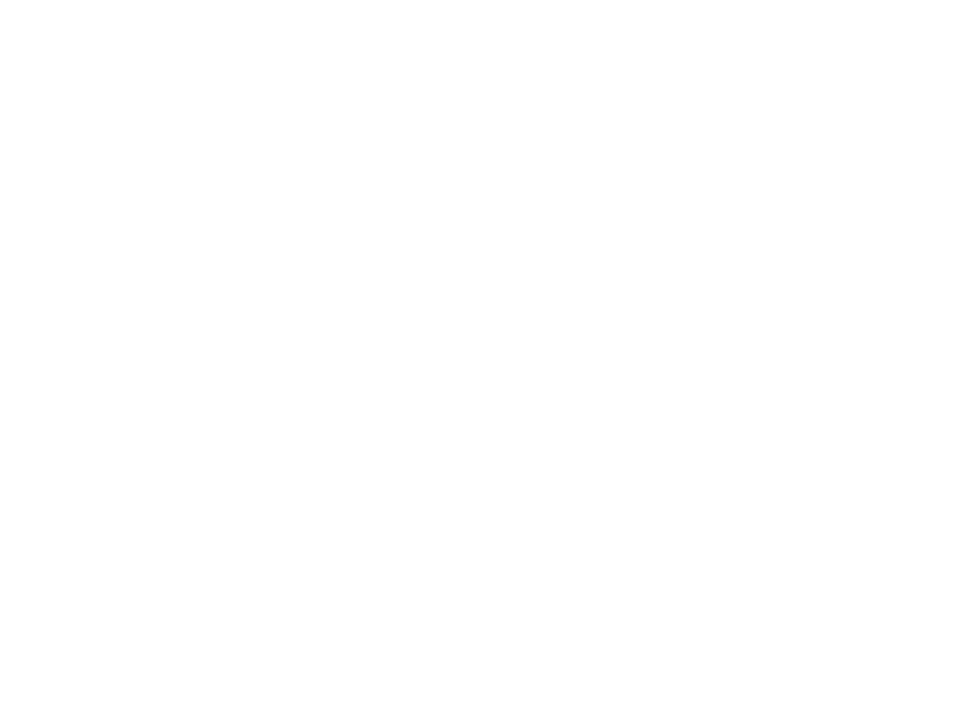

Text(0, 0.5, 'Euclidean distance')

In [10]:
# To plot Euclidean between the vectors (TCP, TCSG, ...) for beam 1 and beam 2
# Data
df = pd.DataFrame({
    'start_ramp': startRampDistance,
    'start_adjust': startAdjustDistance,
    'start_squeeze': startSqueezeDistance,
    'flat_top': flatTopDistance
})
 
# multiple line plot
plt.figure()
plt.yscale('log')
plt.plot('start_ramp', data=df, marker='x', color='black')
plt.plot('start_adjust', data=df, marker='x', color='red')
plt.plot('start_squeeze', data=df, marker='x', color='yellow')
plt.plot('flat_top', data=df, marker='x', color='blue')
plt.legend()
plt.title('Plot of Euclidean distance between the BLM vectors of the two beams')
plt.xlabel('Fill')
plt.ylabel('Euclidean distance')

In [21]:
def scatterPlotLosses(mergedLosses, title=""):
    %matplotlib notebook

    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs = mergedLosses.loc['B1'][mergedLosses.columns[0]]
    ys = mergedLosses.loc['B1'][mergedLosses.columns[1]]
    zs = mergedLosses.loc['B1'][mergedLosses.columns[2]]
    ax.scatter(xs, ys, zs, c='red', label='B1')

    xs = mergedLosses.loc['B2'][mergedLosses.columns[0]]
    ys = mergedLosses.loc['B2'][mergedLosses.columns[1]]
    zs = mergedLosses.loc['B2'][mergedLosses.columns[2]]
    ax.scatter(xs, ys, zs, c='black', label='B2')

    ax.set_xlabel(mergedLosses.columns[0])
    ax.set_ylabel(mergedLosses.columns[1])
    ax.set_zlabel(mergedLosses.columns[2])
    plt.legend()
    plt.title(title)
    plt.show()

<IPython.core.display.Javascript object>


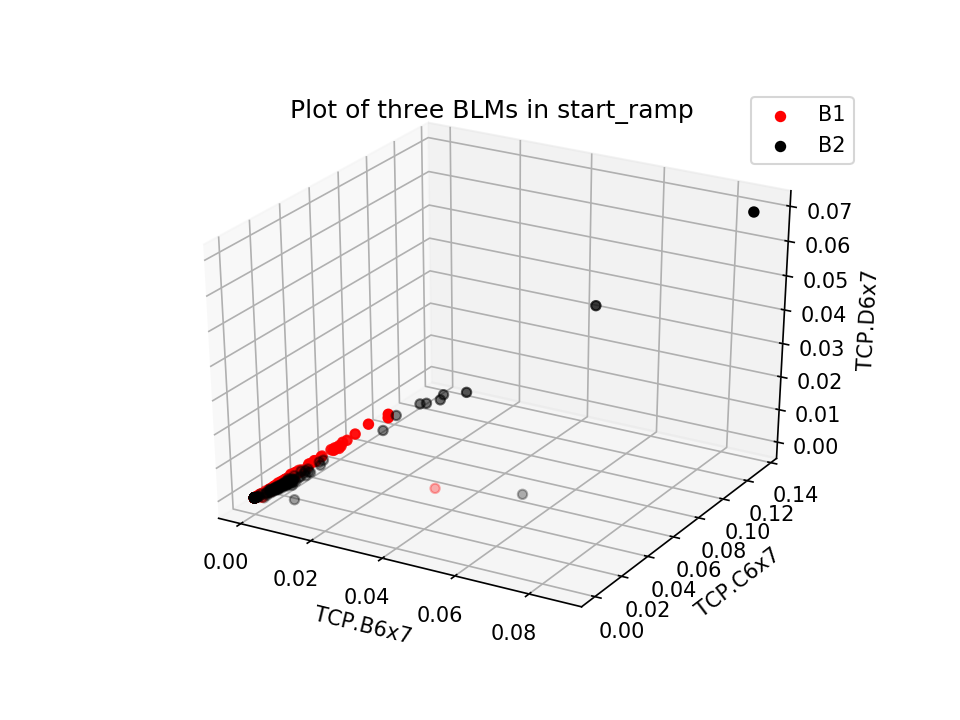

In [22]:
# 3D-plot - each axis is a different BLM.

scatterPlotLosses(startRampLosses[['TCP.B6x7', 'TCP.C6x7', 'TCP.D6x7']], "Plot of three BLMs in start_ramp")

In [13]:
# Min-max scale the features (i.e the BLM values)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

startRampLossesScaled = pd.DataFrame().reindex_like(startRampLosses)
startSqueezeLossesScaled = pd.DataFrame().reindex_like(startSqueezeLosses)
startAdjustLossesScaled = pd.DataFrame().reindex_like(startAdjustLosses)
flatTopLossesScaled = pd.DataFrame().reindex_like(flatTopLosses)

startRampLossesScaled.loc[:] = scaler.fit_transform(startRampLosses.loc[:])
startSqueezeLossesScaled.loc[:] = scaler.fit_transform(startSqueezeLosses.loc[:])
startAdjustLossesScaled.loc[:] = scaler.fit_transform(startAdjustLosses.loc[:])
flatTopLossesScaled.loc[:] = scaler.fit_transform(flatTopLosses.loc[:])

#TODO should I use RobustScaler, due to the presence of outliers?

<IPython.core.display.Javascript object>


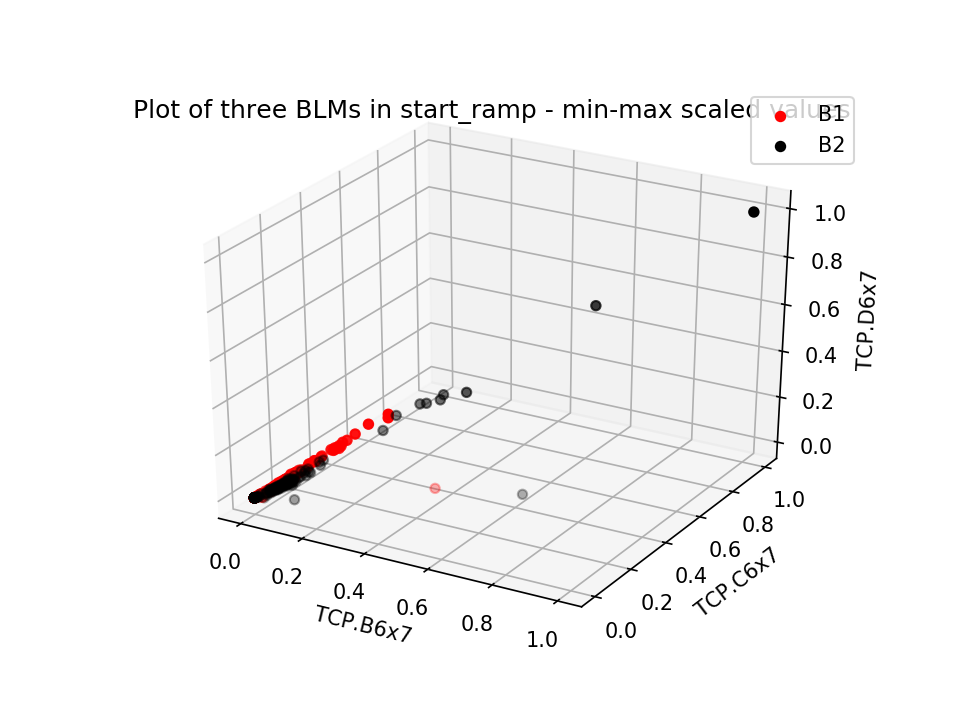

In [23]:
# 3D-plot - scaled BLM values

scatterPlotLosses(startRampLossesScaled[['TCP.B6x7', 'TCP.C6x7', 'TCP.D6x7']], "Plot of three BLMs in start_ramp - min-max scaled values")

In [15]:
# PCA

from sklearn.decomposition import PCA

pca = PCA()  # n_components not set => keep all components
pca.fit(startRampLosses)

#TODO print the BLM names too - i.e. startRampLosses.columns (maybe make a quick dataframe to illustrate)
print('Explained variance ratio of each BLM (sums to 1):')
print(pca.explained_variance_ratio_)

pca = PCA(n_components=3)
startRampLossesPCA = pd.DataFrame(data=pca.fit_transform(startRampLossesScaled), index=startRampLossesScaled.index, columns=['PCA1', 'PCA2', 'PCA3'])
startSqueezeLossesPCA = pd.DataFrame(data=pca.fit_transform(startSqueezeLossesScaled), index=startSqueezeLossesScaled.index, columns=['PCA1', 'PCA2', 'PCA3'])
startAdjustLossesPCA = pd.DataFrame(data=pca.fit_transform(startAdjustLossesScaled), index=startAdjustLossesScaled.index, columns=['PCA1', 'PCA2', 'PCA3'])
flatTopLossesPCA = pd.DataFrame(data=pca.fit_transform(flatTopLossesScaled), index=flatTopLossesScaled.index, columns=['PCA1', 'PCA2', 'PCA3'])

Explained variance ratio of each BLM (sums to 1):
[8.27540592e-01 1.46159232e-01 1.86346815e-02 3.36846942e-03
 1.94226012e-03 1.06639516e-03 6.53206466e-04 2.53880422e-04
 1.00396460e-04 9.81258384e-05 8.03456978e-05 4.70188304e-05
 1.97950837e-05 1.20577254e-05 6.92388776e-06 5.13676094e-06
 3.20130867e-06 2.32546738e-06 1.42680469e-06 1.38191447e-06
 1.06255906e-06 7.00503954e-07 6.29898219e-07 3.82951302e-07
 1.96936212e-07 6.73908938e-08 3.39596663e-08 2.97770989e-08
 2.35552746e-08 9.54120175e-09 4.39069431e-09 2.53968203e-09
 8.95590932e-10 6.46846010e-10 4.63610243e-10 1.81688877e-10
 1.56487404e-10 6.44261786e-11 3.53659009e-11 1.71075734e-11
 1.18512275e-11 4.79607305e-12 3.10072797e-12 1.48377693e-12
 6.79978137e-13 5.33097976e-13 2.67973259e-13]


<IPython.core.display.Javascript object>


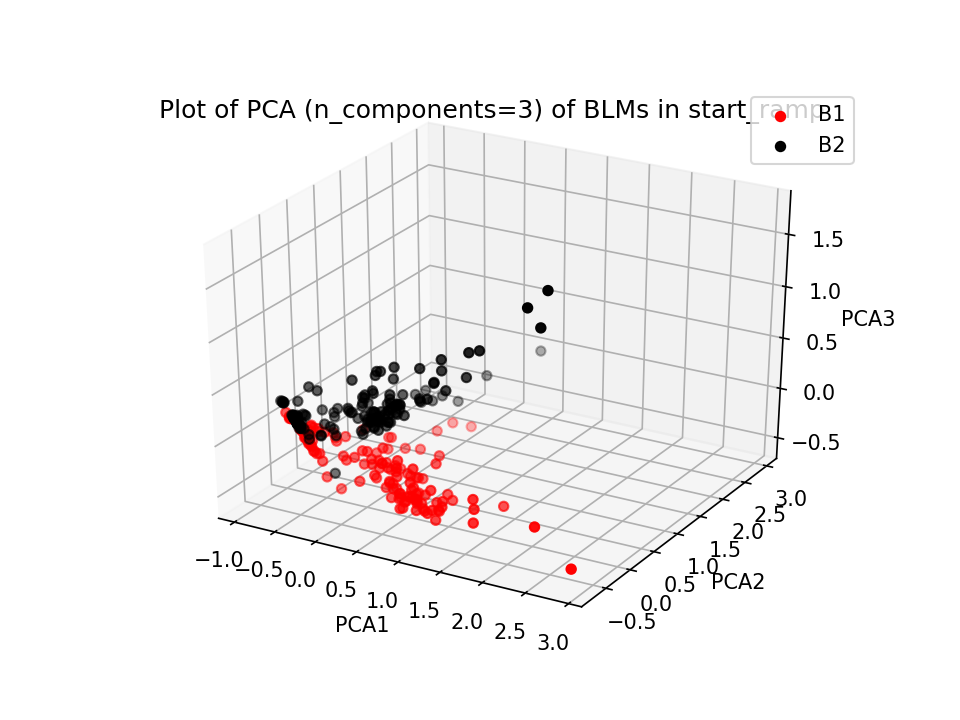

In [24]:
scatterPlotLosses(startRampLossesPCA, "Plot of PCA (n_components=3) of BLMs in start_ramp")

<IPython.core.display.Javascript object>


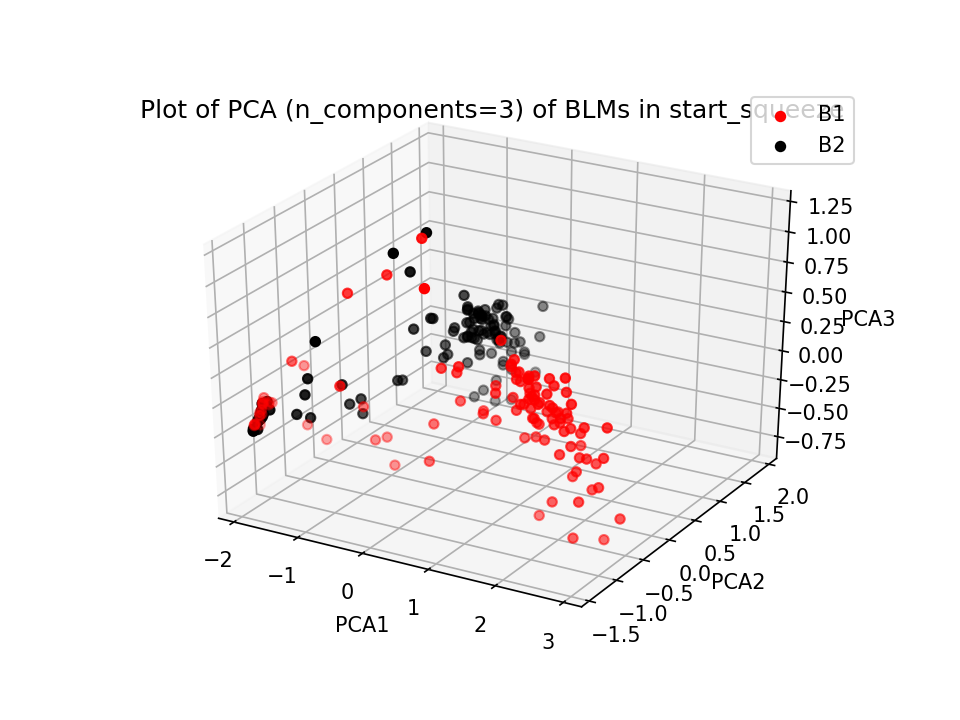

In [25]:
scatterPlotLosses(startSqueezeLossesPCA, "Plot of PCA (n_components=3) of BLMs in start_squeeze")

<IPython.core.display.Javascript object>


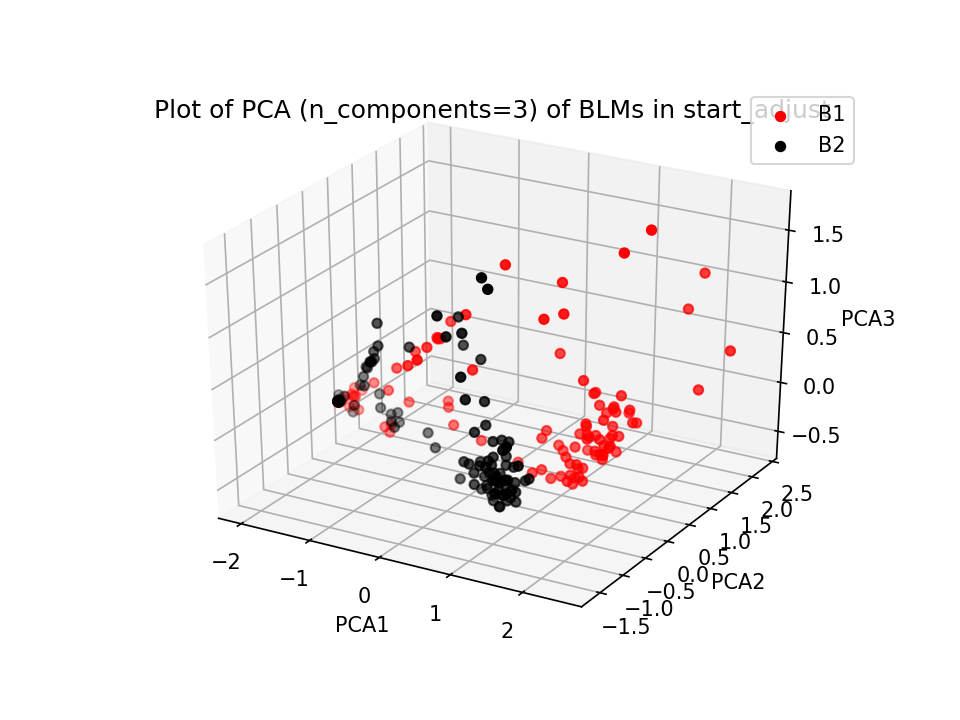

In [26]:
scatterPlotLosses(startAdjustLossesPCA, "Plot of PCA (n_components=3) of BLMs in start_adjust")

<IPython.core.display.Javascript object>


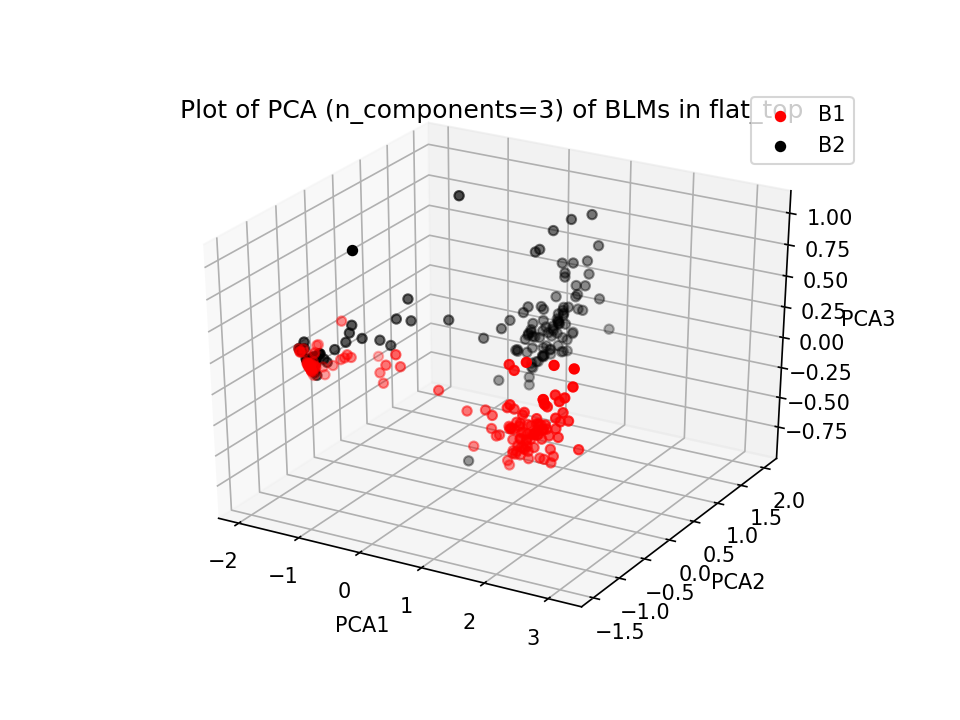

In [175]:
scatterPlotLosses(flatTopLossesPCA, "Plot of PCA (n_components=3) of BLMs in flat_top")